## Imports e configurações

In [1]:
import pandas as pd
import psycopg2
import os
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


load_dotenv("../.env")

DB_CONFIG = {
    'host': os.getenv('POSTGRES_HOST'),
    'port': int(os.getenv('POSTGRES_PORT')),
    'database': os.getenv('POSTGRES_DB'),
    'user': os.getenv('POSTGRES_USER'),
    'password': os.getenv('POSTGRES_PASSWORD')
}


## Carregamento dos dados

In [2]:
QUERY = "SELECT * FROM silver.fifa21_players;"


plt.style.use('seaborn-v0_8')
sns.set_theme(context="notebook", style="whitegrid")

conn = psycopg2.connect(**DB_CONFIG)

df = pd.read_sql(QUERY, conn)

conn.close()

df.head()

/tmp/ipykernel_436218/2403009786.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(QUERY, conn)


player_id                     long_name               name nationality  \
0     158023                  Lionel Messi           L. Messi   Argentina   
1      20801  C. Ronaldo dos Santos Aveiro  Cristiano Ronaldo    Portugal   
2     200389                     Jan Oblak           J. Oblak    Slovenia   
3     192985               Kevin De Bruyne       K. De Bruyne     Belgium   
4     190871    Neymar da Silva Santos Jr.          Neymar Jr      Brazil   

  positions  age  overall_rating  potential_rating                 team  \
0  RW ST CF   33              93                93         FC Barcelona   
1     ST LW   35              92                92             Juventus   
2        GK   27              91                93      Atlético Madrid   
3    CAM CM   29              91                91      Manchester City   
4    LW CAM   28              91                91  Paris Saint-Germain   

  contract_period  ...  defense_work_rate  international_reputation pace  \
0     2004 ~ 2021  ...                Low                         5   85   
1     2018 ~ 2022  ...                Low                         5   89   
2     2014 ~ 2023  ...             Medium                         3   87   
3     2015 ~ 2023  ...               High                         4   76   
4     2017 ~ 2022  ...             Medium                         5   91   

   shooting passing  dribbling_stat defending_stat  physical  hits  \
0        92      91              95             38        65   372   
1        93      81              89             35        77   344   
2        92      78              90             52        90    86   
3        86      93              88             64        78   163   
4        85      86              94             36        59   273   

                  created_at  
0 2026-01-19 03:32:14.324002  
1 2026-01-19 03:32:14.324002  
2 2026-01-19 03:32:14.324002  
3 2026-01-19 03:32:14.324002  
4 2026-01-19 03:32:14.324002  

[5 rows x 76 columns]

## Valor de Mercado vs Overall (Custo-Benefício)

Esse gráfico mostra se um jogador entrega overall alto por um preço baixo.
Jogadores acima da “curva média” são considerados hidden gems, enquanto jogadores muito caros com OVA semelhante a outros são supervalorizados.
Cada ponto representa um jogador do FIFA 21.

In [3]:
fig = px.scatter(
    df,
    x='value_eur',
    y='overall_rating',
    log_x=True,
    hover_name='name',
    hover_data={
        'value_eur': ':,.0f',
        'overall_rating': True,
        'age': True,
        'nationality': True,
        'team': True
    },
    title='Custo-benefício: Valor de Mercado vs Overall'
)

fig.update_xaxes(
    tickvals=[
        100_000,
        250_000,
        500_000,
        1_000_000,
        5_000_000,
        10_000_000,
        50_000_000,
        100_000_000
    ],
    ticktext=[
        '€100k',
        '€250k',
        '€500k',
        '€1M',
        '€5M',
        '€10M',
        '€50M',
        '€100M'
    ],
    title='Valor de Mercado (€)'
)

fig.update_layout(
    yaxis_title='Overall',
    template='plotly_white'
)

fig.show()

## Distribuição de Overall dos Jogadores
Este gráfico mostra como os jogadores estão distribuídos em termos de qualidade geral (OVA).
Ele ajuda o jogador a entender se a maioria dos atletas do jogo é mediana, boa ou elite.

In [4]:
df["age"] = pd.to_numeric(df["age"], errors="coerce")
df["best_overall_rating"] = pd.to_numeric(df["best_overall_rating"], errors="coerce")

fig = px.scatter(
    df,
    x="age",
    y="best_overall_rating",
    hover_name="name",
    hover_data={
        "age": True,
        "best_overall_rating": True,
        "positions": True,
        "team": True
    },
    opacity=0.6,
    title="Relação entre Idade e Overall dos Jogadores"
)

fig.update_traces(marker=dict(size=6))

fig.update_layout(
    xaxis_title="Idade",
    yaxis_title="Overall",
    template="plotly_white"
)

fig.show()

## Potencial de Crescimento
Esse gráfico mostra os jogadores com o maior potencial de crescimento. Permite a contratação barata de um

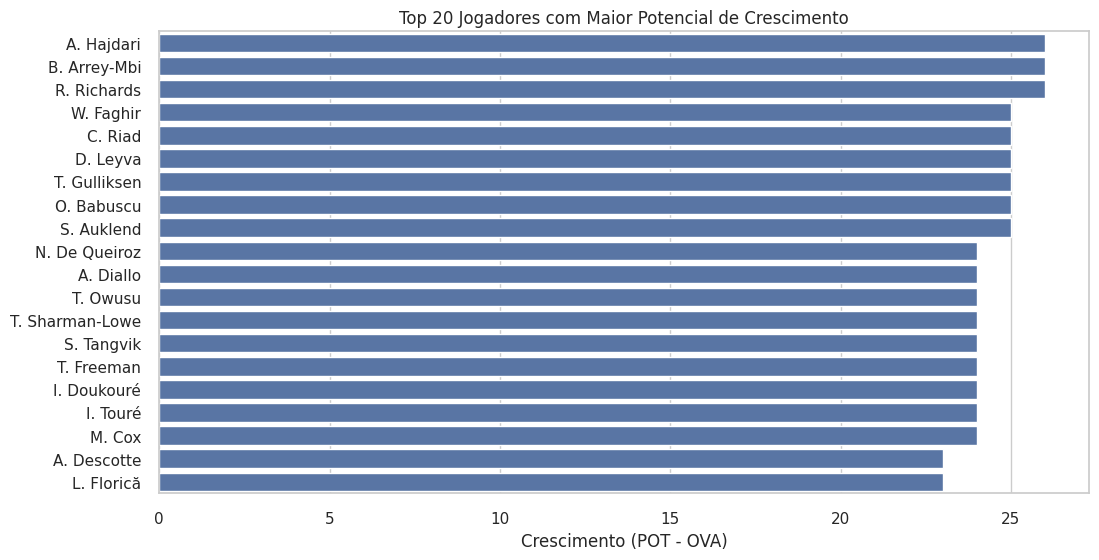

In [5]:
df['growth'] = df['potential_rating'] - df['overall_rating']
top_growth = df.sort_values('growth', ascending=False).head(20)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=top_growth,
    x='growth',
    y='name'
)

plt.title('Top 20 Jogadores com Maior Potencial de Crescimento')
plt.xlabel('Crescimento (POT - OVA)')
plt.ylabel('')
plt.show()


## Distribuição de Posições dos Jogadores
O gráfico mostra as 10 posições mais comuns entre os jogadores do FIFA 21.
As barras representam a quantidade de jogadores disponíveis em cada posição, permitindo identificar onde há maior oferta de atletas no jogo.

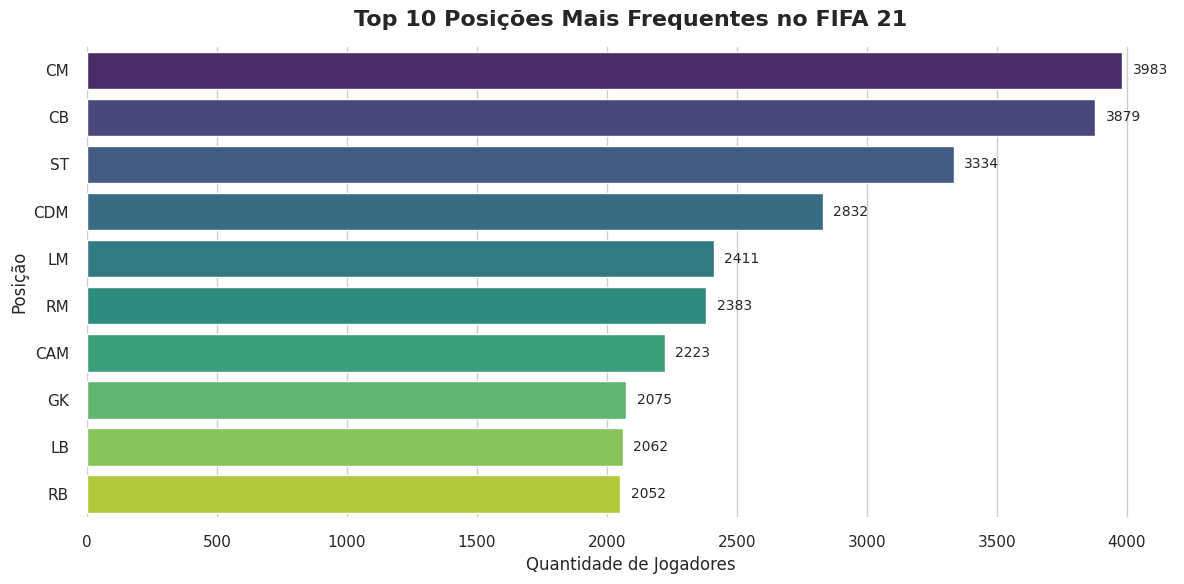

In [6]:
positions = (
    df["positions"]
    .dropna()
    .str.split(" ")
    .explode()
)

sns.set_theme(style="whitegrid", context="notebook")

top_positions = positions.value_counts().head(10)

fig, ax = plt.subplots(figsize=(12, 6))

bars = sns.barplot(
    x=top_positions.values,
    y=top_positions.index,
    hue=top_positions.index,  
    palette="viridis",
    legend=False,
    ax=ax
)

ax.set_title(
    "Top 10 Posições Mais Frequentes no FIFA 21",
    fontsize=16,
    weight="bold",
    pad=15
)
ax.set_xlabel("Quantidade de Jogadores", fontsize=12)
ax.set_ylabel("Posição", fontsize=12)

sns.despine(left=True, bottom=True)

for i, value in enumerate(top_positions.values):
    ax.text(
        value + (top_positions.values.max() * 0.01),
        i,
        f"{value}",
        va="center",
        fontsize=10
    )

plt.tight_layout()
plt.show()

## Overall Médio por Time

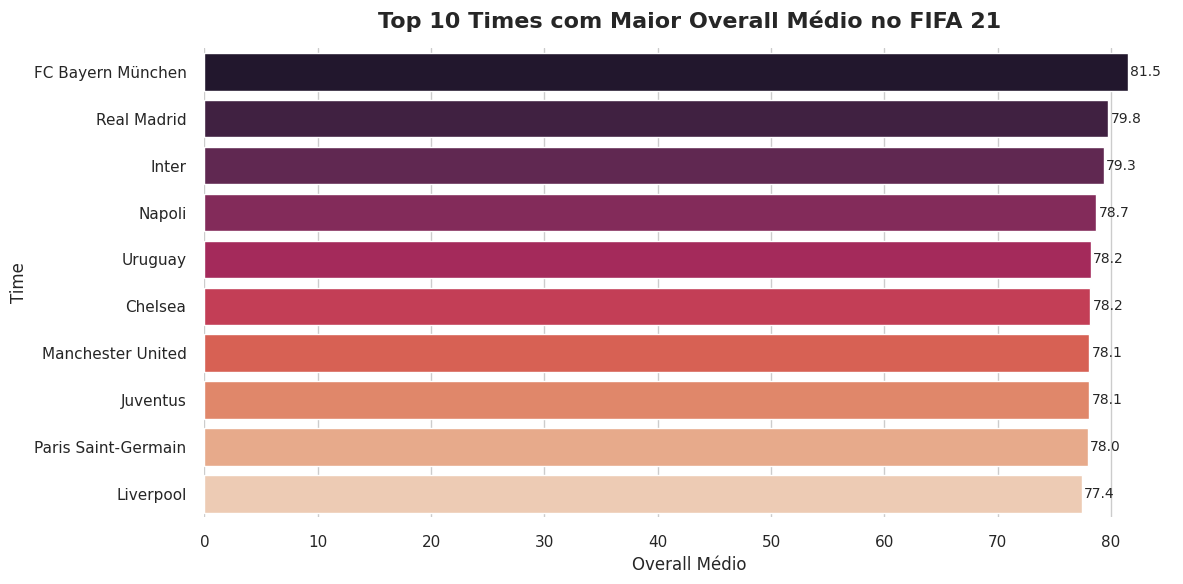

In [7]:
sns.set_theme(style="whitegrid", context="notebook")

team_overall = (
    df
    .dropna(subset=["team", "overall_rating"])
    .groupby("team", as_index=False)
    .agg(
        overall_medio=("overall_rating", "mean"),
        qtd_jogadores=("overall_rating", "count")
    )
)

team_overall = team_overall[team_overall["qtd_jogadores"] >= 10]

top_teams_overall = team_overall.sort_values(
    "overall_medio", ascending=False
).head(10)

fig, ax = plt.subplots(figsize=(12, 6))

sns.barplot(
    x="overall_medio",
    y="team",
    hue="team",     
    data=top_teams_overall,
    palette="rocket",
    legend=False,      
    ax=ax
)

ax.set_title(
    "Top 10 Times com Maior Overall Médio no FIFA 21",
    fontsize=16,
    weight="bold",
    pad=15
)
ax.set_xlabel("Overall Médio", fontsize=12)
ax.set_ylabel("Time", fontsize=12)

for i, value in enumerate(top_teams_overall["overall_medio"]):
    ax.text(
        value + 0.2,
        i,
        f"{value:.1f}",
        va="center",
        fontsize=10
    )

sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.show()

## Perfil Físico Médio dos Jogadores

In [8]:
df["height_cm"] = pd.to_numeric(df["height_cm"], errors="coerce")
df["weight_kg"] = pd.to_numeric(df["weight_kg"], errors="coerce")

avg_height = df["height_cm"].mean()
avg_weight = df["weight_kg"].mean()


In [9]:
physical_avg = pd.DataFrame({
    "Métrica": ["Altura Média (cm)", "Peso Médio (kg)"],
    "Valor": [avg_height, avg_weight]
})



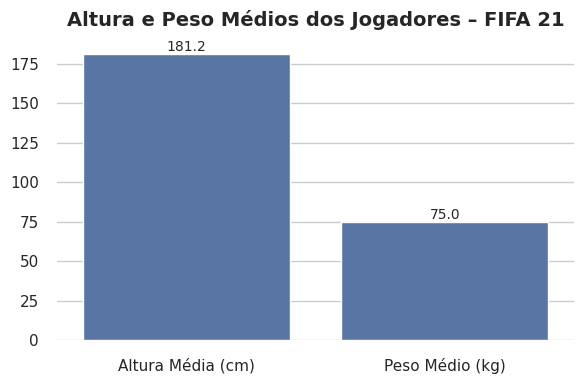

In [10]:
# %%
fig, ax = plt.subplots(figsize=(6, 4))

sns.barplot(
    data=physical_avg,
    x="Métrica",
    y="Valor",
    ax=ax
)

ax.set_title(
    "Altura e Peso Médios dos Jogadores – FIFA 21",
    fontsize=14,
    weight="bold",
    pad=10
)

ax.set_ylabel("")
ax.set_xlabel("")

for i, value in enumerate(physical_avg["Valor"]):
    ax.text(
        i,
        value,
        f"{value:.1f}",
        ha="center",
        va="bottom",
        fontsize=10
    )

sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

## Valor Médio de Mercado por Idade

In [11]:

df["age"] = pd.to_numeric(df["age"], errors="coerce")
df["value_eur"] = pd.to_numeric(df["value_eur"], errors="coerce")

df_age_value = df.dropna(subset=["age", "value_eur"])

In [12]:
# %%
df_age_value = (
    df
    .dropna(subset=["age", "value_eur"])
    .groupby("age", as_index=False)
    .agg(valor_medio=("value_eur", "mean"))
)

fig = px.line(
    df_age_value,
    x="age",
    y="valor_medio",
    markers=True,
    title="Valor Médio de Mercado por Idade – FIFA 21"
)

fig.update_yaxes(
    tickvals=[1e5, 5e5, 1e6, 5e6, 1e7, 5e7],
    ticktext=["€100k", "€500k", "€1M", "€5M", "€10M", "€50M"],
    title="Valor Médio (€)"
)

fig.update_layout(
    xaxis_title="Idade",
    template="plotly_white"
)

fig.show()

## Top 10 Times com Maior Tempo Médio de Contrato

In [13]:
df_contract = df.dropna(subset=["team", "contract_period"]).copy()

df_contract[["contract_start", "contract_end"]] = (
    df_contract["contract_period"]
    .str.split("~", expand=True)
)

df_contract["contract_start"] = pd.to_numeric(
    df_contract["contract_start"].str.strip(),
    errors="coerce"
)

df_contract["contract_end"] = pd.to_numeric(
    df_contract["contract_end"].str.strip(),
    errors="coerce"
)

df_contract["contract_duration"] = (
    df_contract["contract_end"] - df_contract["contract_start"]
)

df_contract = df_contract[df_contract["contract_duration"] > 0]


In [14]:
team_contract_avg = (
    df_contract
    .groupby("team", as_index=False)
    .agg(
        tempo_medio_contrato=("contract_duration", "mean"),
        qtd_jogadores=("contract_duration", "count")
    )
)

# Filtrar times com amostra mínima
team_contract_avg = team_contract_avg[
    team_contract_avg["qtd_jogadores"] >= 10
]

top_10_contracts = (
    team_contract_avg
    .sort_values("tempo_medio_contrato", ascending=False)
    .head(10)
)


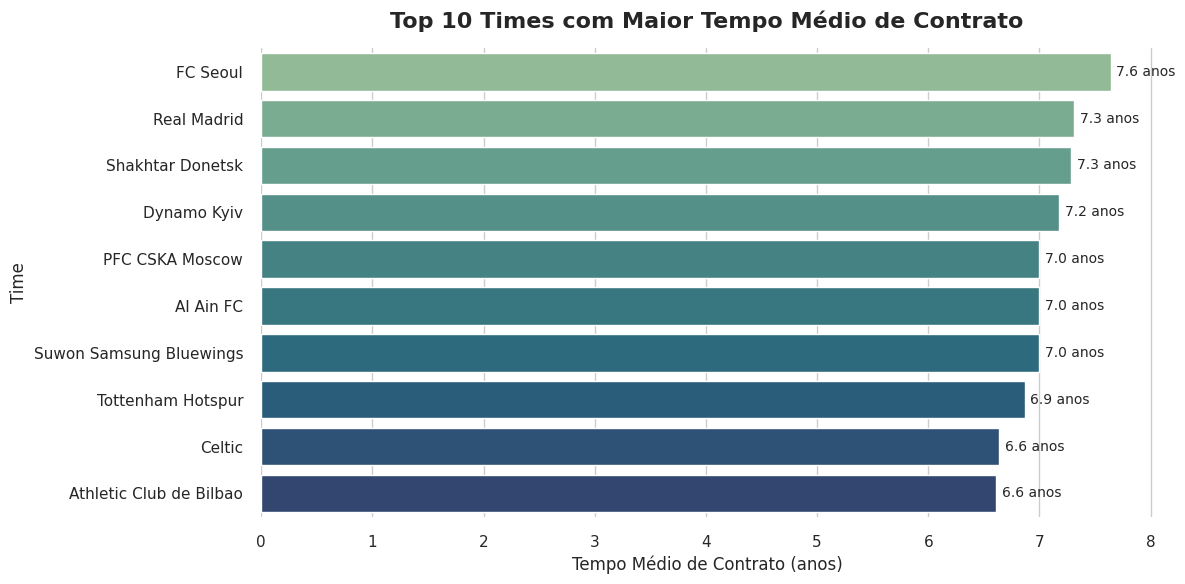

In [15]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.barplot(
    data=top_10_contracts,
    x="tempo_medio_contrato",
    y="team",
    hue="team",
    palette="crest",
    legend=False,
    ax=ax
)

ax.set_title(
    "Top 10 Times com Maior Tempo Médio de Contrato",
    fontsize=16,
    weight="bold",
    pad=15
)
ax.set_xlabel("Tempo Médio de Contrato (anos)", fontsize=12)
ax.set_ylabel("Time", fontsize=12)

for i, value in enumerate(top_10_contracts["tempo_medio_contrato"]):
    ax.text(
        value + 0.05,
        i,
        f"{value:.1f} anos",
        va="center",
        fontsize=10
    )

sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()